<center>
<img src="../logo.png" height="900"> 
</center>


#  Извлечение признаков (Feature exctraction) из временных рядов 

__Тут выражается благодарность [Сергееву Дмитрию](https://github.com/DmitrySerg) за помощь в создании материалов.__ 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
import warnings
warnings.filterwarnings('ignore')

Работать будем всё с теми же рядами, что и до этого. 

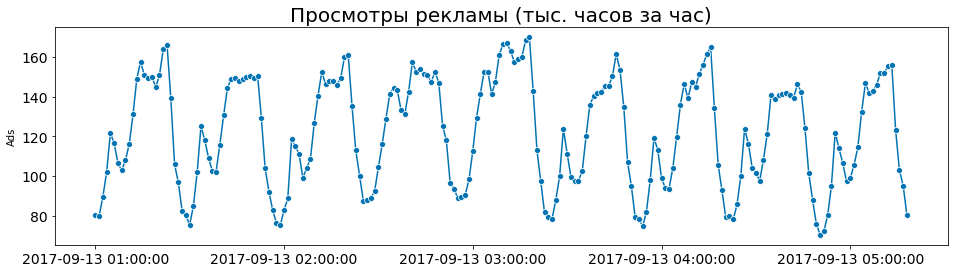

In [3]:
from sktime.utils.plotting import plot_series

ads = pd.read_csv('data/ads.csv', index_col=['Time'], parse_dates=['Time'])

y = ads.Ads/10**3  # в тысячах :)

plot_series(y)
plt.title('Просмотры рекламы (тыс. часов за час)', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 14);

# 1. Извлекаем признаки вручную 

Итак, для модели нужны признаки, а у нас есть только одномерный временной ряд, что можно придумать?

* Конечно же, лаги временного ряда
* Статистики по окнам:
    - Минимальное/максимальное значение ряда в окне
    - Среднеё/медианное значение по окну
    - Дисперсия по окну
    - и т.д.
* Признаки из самой даты и времени:
    - Минута часа, час дня, день недели, месяц года и т.д.
    - Является ли день праздником/выходным/специфическим днём
* Кодирование средним
* Прогнозы других моделей (но тут в скорости можно потерять)

Пройдемся по некоторым из способов и посмотрим, что мы можем извлечь из нашего временного ряда с рекламой

### Лаги временного ряда

Сдвигая ряд на $n$ шагов мы получаем столбец-признак, в котором текущему значению ряда в момент $t$ будет соответствовать его значение в момент времени $t-n$. Таким образом, если сделать отступ в 1 шаг, то модель, обученная на таком признаке, будет способна давать предсказание на 1 шаг вперед, зная текущее состояние ряда. Увеличивая сдвиг, например, до 6 лага позволит модели делать предсказания на 6 шагов вперёд, однако опираться она будет на данные, которые видела 6 временных периодов назад и если за это время что-то кардинально поменялось, модель сразу не уловит изменений и выдаст прогноз с большой ошибкой. Поэтому при выборе начального лага приходится балансировать между желанием получить предсказания на бОльшее число периодов вперёд и приемлемым качеством предсказания

In [32]:
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

In [5]:
# Добавляем колонки с лагами
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [6]:
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 17:00:00,151790,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0
2017-09-21 18:00:00,155665,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


Шикарно, у нас есть датасет, почему бы не построить модель!

In [7]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

In [8]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=48)

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
mape(y_pred, y_test)

5.805969934554358

Добавим кросс-валидацию.

In [10]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import make_scorer

mape_score = make_scorer(mape, greater_is_better=True)

tscv = TimeSeriesSplit(n_splits=5)

model = LinearRegression()
cv = cross_val_score(model, X_train, y_train, 
                            cv=tscv, 
                            scoring=mape_score)
cv

array([ 5.65855204, 10.51769802,  7.14515863, 19.88705111,  6.37870015])

In [11]:
cv.mean()

9.917431990767303

In [12]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

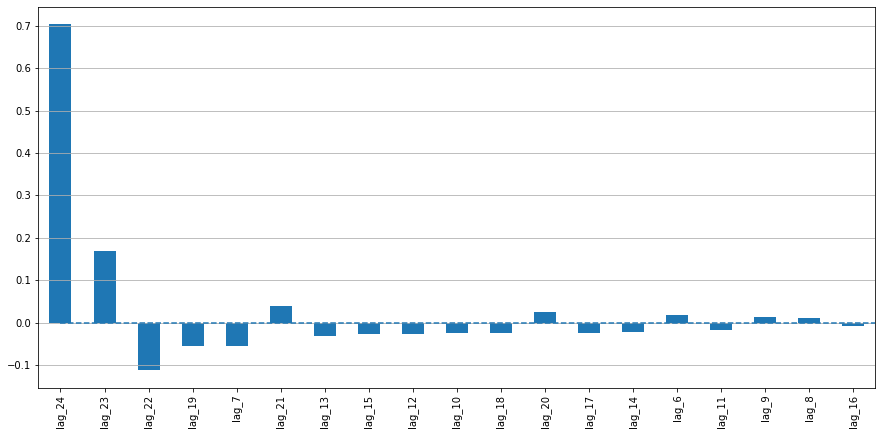

In [13]:
plotCoefficients(lr)

Неудивительно, что $24$ лаг оказывается настолько важен. По факту мы просто-напросто, использовав лаги продублировали модель авторегрессии своими руками. 

Добавим в датасет час, день недели и выходной в качестве категориальных переменных. Для этого переводим имеющийся в датафрейме индекс в формат `datetime`, и извлекаем из него `hour` и `weekday`.

In [14]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


Можно визуализировать получившиеся признаки

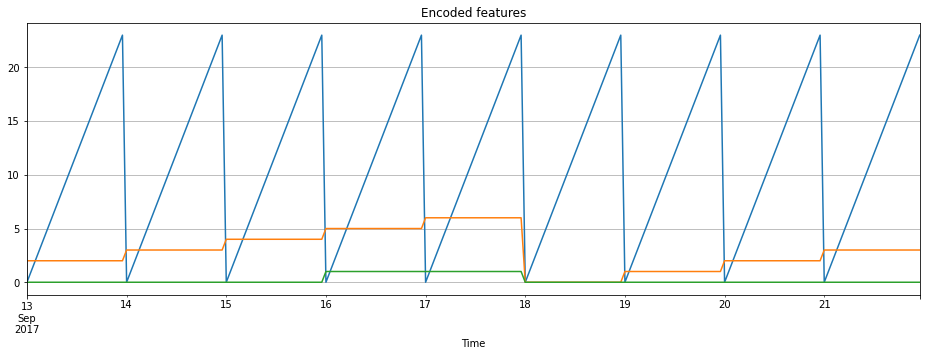

In [15]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

Так как теперь у нас данные в разном масштабе - десятки тысяч в лагах и единицы в категориях, имеет смысл привести всё к одному масштабу, чтобы можно было по-прежнему исследовать коэффициенты модели. Для этого воспользуемся `StandardScaler`. Также, раз мы работаем с линейной моделью, имеет смысл преобразовать категориальные переменные в дамми.

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [17]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=48)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
mape(y_pred, y_test)

5.575669807474357

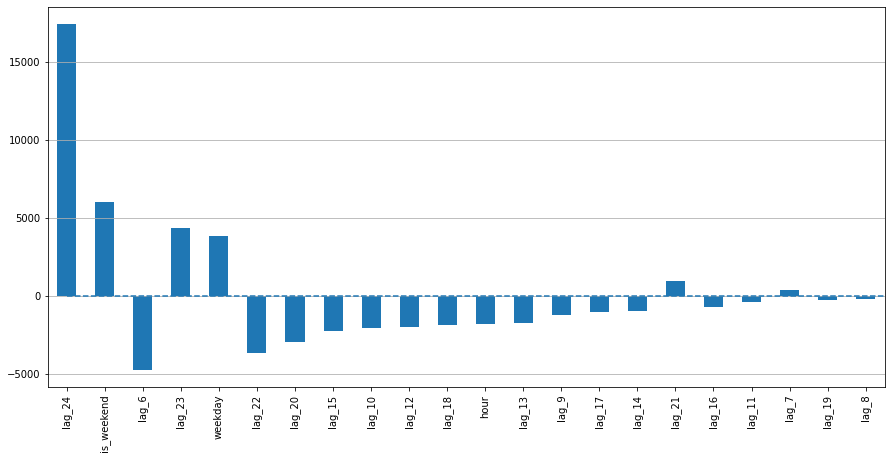

In [18]:
plotCoefficients(lr)

Ошибка на тесте еще немного уменьшилась, и по коэффициентам видно, что день недели и выходной - довольно неплохие признаки. По аналогии можно попробовать другие классические модели. Понятное дело, что надо будет рабтоать с рядом очень осторожно, чтобы ненароком не заглянуть в будущее. Более того, можно добавлять в выборку различные экзогенные переменные.

# 2. А вы и признаки за меня придумывать будете? 

<img src="https://tsfresh.readthedocs.io/en/latest/_images/introduction_ts_exa_features.png" width=500>

Основная идея библиотеки `tsfresh` - сгенерировать как можно больше признаков (если позволяют вычислительные ресурсы), а затем при помощи моделей или статистических критериев из этих признаков уже можно отобрать только те, которые релевантны для текущей задачи. Признаки могут быть как достаточно привычные - те же средние, максимальные и минимальные значения, так и довольно экзотичные, например, p-value коэффициента наклона линии тренда в текущем скользящем окне. Безусловно, не все эти признаки окажутся полезными (некоторые и вовсе могут оказаться константными), поэтому библиотека предоставляет небольшой инструментарий, который позволит быстро убрать самый откровенный мусор. 

Давайте разберём всё на интересном примере - распознавание активности человека по данным акселерометра с мобильного телефона: 

In [19]:
# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Загрузим данные, которые удобно находятся в самой библиотеке. Суммарно у нас есть 7352 наблюдений, каждому из которых сооветствуют 128 показаний акселерометра и одна из шести возможных активностей (подробное описание набора данных можно найти [здесь](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones))

In [21]:
download_har_dataset()
data = load_har_dataset()
y = load_har_classes()
print(data.shape)
data.head()

(7352, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


Для начала, давайте обучим простую модель на сырых данных, т.е. возьмем все 128 наблюдений акселерометра и возьмём их в качестве признаков в случайный лес. 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2)

cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

              precision    recall  f1-score   support

           1       0.66      0.67      0.67       248
           2       0.59      0.60      0.59       219
           3       0.71      0.67      0.69       201
           4       0.39      0.36      0.37       262
           5       0.41      0.43      0.42       269
           6       0.53      0.56      0.54       272

    accuracy                           0.54      1471
   macro avg       0.55      0.55      0.55      1471
weighted avg       0.54      0.54      0.54      1471



Хорошо видно, что некоторые классы модель распознает с большей точностью, чем другие (обычно на этом датасете сложнее всего отличить сидячих от стоячих людей).

В `tsfresh` есть различные предустановленные варианты извлечения признаков, которыми можно воспользоваться из коробки и особо не думать насчет содержания. Отличаются они лишь количеством рассчитываемых признаков, а значит, скоростью обработки данных и количеством информации, которую эти признаки смогут передать. При желании, можно также вручную изменять набор рассчитываемых признаков. 

Первый и самый базовый набор признаков даёт `MinimalFCParameters`. Используя такую настройку мы получим джентельменский набор признаков для каждого наблюдения, а именно: сумму, медиану, среднее, длину, стандартное отклонение, дисперсию, максимальное и минимальное значения каждого ряда. 

Обычно такие признаки не дают хорошего качества (всё-таки их не так много и они представляют собой лишь базовые статистики, описывающие распределение значений). Однако такой набор удобно использовать для прототипирования, построения бейзлайнов или в случае, когда получение других признаков занимает слишком много времени.

In [23]:
settings_minimal = settings.MinimalFCParameters()
settings_minimal

{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}

Теперь посмотрим, как можно скомбинировать несколько разных вариантов извлечения признаков. Добавим к текущему минимальному набору еще один - `TimeBasedFCParameters`. Этот метод посчитает по нашему ряду линейный тренд, возьмет оттуда значение коэффициента $R^2$, константу, угол наклона, стандартную ошибку и p-value и всё это сделает новыми признаками для объекта. При помощи простого совмещения двух словарей с правилами мы получаем уже чуть более интересный набор признаков, который по-прежнему будет достаточно быстро считаться даже на больших датасетах.

In [24]:
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)
settings_time

{'linear_trend_timewise': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],
 'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}

Следующий набор - `EfficientFCParameters`. Здесь число различных признаков уже заметно выше, чем в предыдущих вариантах. Рассчитываются коэффициент ассиметрии, куртосис, считается, сколько раз повторялось значение минимума и максимума, различные квантили, оконные статистики, автокорреляции и многое-многое другое. `Efficient` этот набор потому, что он по-прежнему относительно быстро считается и не требует значительных вычислительных затрат на построение признакового пространства.

In [25]:
settings_efficient = settings.EfficientFCParameters()
settings_efficient

{'variance_larger_than_standard_deviation': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'has_duplicate': None,
 'sum_values': None,
 'abs_energy': None,
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variation_coefficient': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'sum_of_reoccurring_values': None,
 'sum_of_reoccurring_data_points': None,
 'ratio_value_number_to_time_series_length': None,
 'maximum': None,
 '

Наконец, самый большой и полный вариант - `ComprehensiveFCParameters`, в котором добавляются неэффективные в вычислительном плане признаки, но вполне возможно, что они дадут дополнительный прирост в качесве при обучении моделей.

In [26]:
settings_comprehensive = settings.ComprehensiveFCParameters()
len(settings_comprehensive)

71

Давайте возьмем эффективный список параметров и построим с его помощью наше новое признаковое пространство. 

Для начала нужно преобразовать датасет в `long` формат, необходимый для работы библиотеки. В этом формате у нас будет всего два столбца: в первом будут храниться все наблюдения акселерометров, во втором - соответствующий индекс наблюдения.

In [27]:
data_long = pd.DataFrame({0: data.values.flatten(),
                          1: np.arange(data.shape[0]).repeat(data.shape[1])})
print(data_long.shape)
data_long.head()

(941056, 2)


,0,1
0,0.000181,0
1,0.010139,0
2,0.009276,0
3,0.005066,0
4,0.010810,0


В результате наш датасет удлиннился практически до одного миллиона строк.  

Извлекаем признаки при помощи `extract_features`, указав в качестве параметров для извлечения наш эффективный список. Также укажем параметр для `impute_function`, передав туда функцию `impute`, импортированную выше из `tsfresh.utilities.dataframe_functions`. Эта функция автоматически заполнит все пропуски в получившемся датасете (если они там внезапно появятся)

In [28]:
X = extract_features(
    data_long, column_id=1, 
    impute_function=impute, 
    default_fc_parameters=settings_efficient,
    n_jobs=6
)
print(X.shape)

Feature Extraction: 100%|██████████| 30/30 [02:58<00:00,  5.94s/it]


(7352, 773)


Спустя пять минут работы библиотеки, получаем готовый датасет, где каждому наблюдению соответсвуют уже не 128 сырых значений акселерометра, а 788 извлеченных признаков.

Попробуем теперь обучить модель на них!

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

              precision    recall  f1-score   support

           1       0.94      0.92      0.93       258
           2       0.83      0.91      0.87       200
           3       0.93      0.87      0.90       207
           4       0.38      0.39      0.38       259
           5       0.45      0.44      0.45       278
           6       0.56      0.54      0.55       269

    accuracy                           0.66      1471
   macro avg       0.68      0.68      0.68      1471
weighted avg       0.66      0.66      0.66      1471



Ура, действительно, признаки оказались полезными и качество предсказаний заметно подросло по всем классам. Но скорее всего, многие из извлеченных признаков на самом деле не нужны для построения предсказаний и могут быть спокойно удалены. 

Для этого в библиотеке есть метод `select_features`, который рассчитывает важность текущего признака для предсказания класса. После рассчета ненужные признаки отбрасываются по `p-value`, при этом в функцию включена поправка Бенджамини-Иекутиели на множественное тестирование.

In [30]:
relevant_features = set()

for label in y.unique():
    # select_features работает с бинарной классификацией, поэтому переводим задачу
    # в бинарную для каждого класса и повторяем по всем классам
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train, y_train_binary)
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

len(relevant_features)

373

В результате получили заметно меньшей признаковое пространство, попробуем снова построить модель.

In [31]:
X_train_filtered = X_train[list(relevant_features)]
X_test_filtered = X_test[list(relevant_features)]

cl = DecisionTreeClassifier()
cl.fit(X_train_filtered, y_train)
print(classification_report(y_test, cl.predict(X_test_filtered)))

              precision    recall  f1-score   support

           1       0.94      0.93      0.93       258
           2       0.83      0.90      0.86       200
           3       0.93      0.86      0.90       207
           4       0.33      0.34      0.34       259
           5       0.43      0.41      0.42       278
           6       0.56      0.57      0.56       269

    accuracy                           0.65      1471
   macro avg       0.67      0.67      0.67      1471
weighted avg       0.65      0.65      0.65      1471



Отлично, отбросив мусорные признаки мы не только упростили модель, но еще и получили более высокое качество!

![](https://s.auto.drom.ru/i24217/com/431/430616.jpg)